In [ ]:
# Step 1: Environment setup

In [1]:
!pip install -q tensorflow keras torch scikit-learn pandas matplotlib

import os, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow:", tf.__version__)

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional: reduce TF logging noise
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Create folders for saving artifacts
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("figures", exist_ok=True)

TensorFlow: 2.20.0


In [2]:
import os
import matplotlib.pyplot as plt

def plot_history(histories, title="Training curves", filename="training_curves.png"):
    """
    histories: dict of name -> Keras History
    Plots train/val loss for each history
    """
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history.get("loss", []), label=f"{name} - train loss")
        plt.plot(h.history.get("val_loss", []), label=f"{name} - val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

def plot_accuracy(histories, title="Accuracy curves", filename="accuracy_curves.png"):
    """
    histories: dict of name -> Keras History
    Plots train/val accuracy for each history
    """
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history.get("accuracy", []), label=f"{name} - train acc")
        plt.plot(h.history.get("val_accuracy", []), label=f"{name} - val acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()


In [3]:
# Step 2: Load and prepare the dataset

In [4]:
VOCAB_SIZE = 10000        # num_words in imdb.load_data
MAXLEN = 200              # sequence length (you will vary this later)

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=VOCAB_SIZE)

X_train = pad_sequences(X_train, maxlen=MAXLEN)
X_test  = pad_sequences(X_test,  maxlen=MAXLEN)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train labels distribution:", np.bincount(y_train))
print("Test labels distribution:", np.bincount(y_test))

Train shape: (25000, 200) Test shape: (25000, 200)
Train labels distribution: [12500 12500]
Test labels distribution: [12500 12500]


In [5]:
def build_rnn_model(vocab_size, maxlen, embedding_dim=64, rnn_units=64, learning_rate=1e-3, clipnorm=None):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim)
,
        SimpleRNN(rnn_units),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def build_lstm_model(vocab_size, maxlen, embedding_dim=64, lstm_units=64, learning_rate=1e-3, clipnorm=None):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim)
,
        LSTM(lstm_units),
        Dropout(0.2),
        Dense(1, activation="sigmoid")
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=5, batch_size=64, log_name="run.csv"):
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=1, restore_best_weights=True),
        CSVLogger(os.path.join("logs", log_name))
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

def evaluate_model(model, X_test, y_test):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    perplexity = float(np.exp(loss))  # common proxy when loss is cross-entropy
    return {"loss": float(loss), "accuracy": float(acc), "perplexity": perplexity}

def classification_details(model, X_test, y_test):
    probs = model.predict(X_test, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    report = classification_report(y_test, preds, digits=4)
    cm = confusion_matrix(y_test, preds)
    return report, cm

def plot_history(histories, title="Training curves", filename="training_curves.png"):
    # histories: dict name -> history
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history["loss"], label=f"{name} - train loss")
        plt.plot(h.history["val_loss"], label=f"{name} - val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

def plot_accuracy(histories, title="Accuracy curves", filename="accuracy_curves.png"):
    plt.figure()
    for name, h in histories.items():
        plt.plot(h.history["accuracy"], label=f"{name} - train acc")
        plt.plot(h.history["val_accuracy"], label=f"{name} - val acc")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    path = os.path.join("figures", filename)
    plt.savefig(path, dpi=200)
    plt.show()

In [6]:
# Baseline RNN training

In [7]:
rnn_baseline = build_rnn_model(
    vocab_size=VOCAB_SIZE,
    maxlen=MAXLEN,
    embedding_dim=64,
    rnn_units=64,
    learning_rate=1e-3,
    clipnorm=None
)

rnn_baseline.summary()

rnn_hist = train_model(
    rnn_baseline,
    X_train, y_train,
    X_test, y_test,
    epochs=5,
    batch_size=64,
    log_name="rnn_baseline.csv"
)

rnn_baseline.save(os.path.join("models", "rnn_baseline.keras"))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 80ms/step - accuracy: 0.6466 - loss: 0.6035 - val_accuracy: 0.7300 - val_loss: 0.5330
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.8274 - loss: 0.3997 - val_accuracy: 0.8238 - val_loss: 0.4236
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - accuracy: 0.8694 - loss: 0.3112 - val_accuracy: 0.7998 - val_loss: 0.4687


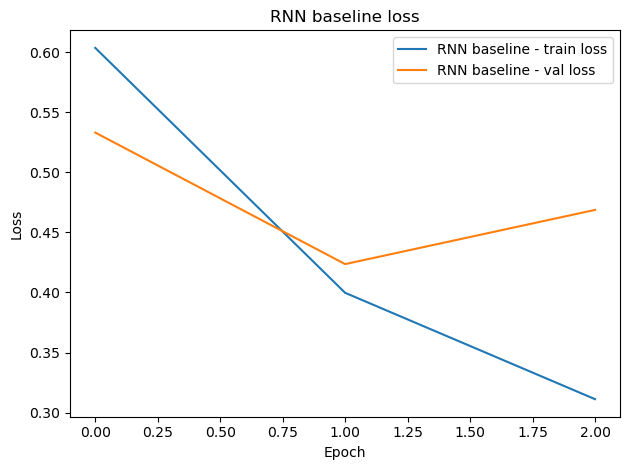

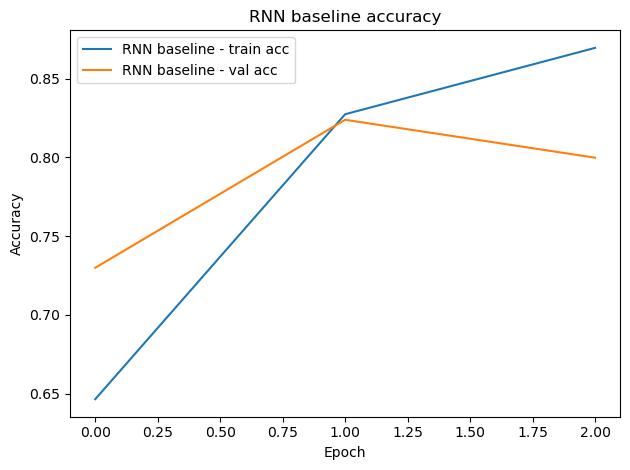

RNN baseline metrics: {'loss': 0.42359527945518494, 'accuracy': 0.8238400220870972, 'perplexity': 1.5274432809936944}

RNN Classification Report:
               precision    recall  f1-score   support

           0     0.8353    0.8068    0.8208     12500
           1     0.8132    0.8409    0.8268     12500

    accuracy                         0.8238     25000
   macro avg     0.8242    0.8238    0.8238     25000
weighted avg     0.8242    0.8238    0.8238     25000

RNN Confusion Matrix:
 [[10085  2415]
 [ 1989 10511]]


In [8]:
plot_history({"RNN baseline": rnn_hist}, title="RNN baseline loss", filename="rnn_baseline_loss.png")
plot_accuracy({"RNN baseline": rnn_hist}, title="RNN baseline accuracy", filename="rnn_baseline_acc.png")

rnn_base_metrics = evaluate_model(rnn_baseline, X_test, y_test)
print("RNN baseline metrics:", rnn_base_metrics)

rnn_report, rnn_cm = classification_details(rnn_baseline, X_test, y_test)
print("\nRNN Classification Report:\n", rnn_report)
print("RNN Confusion Matrix:\n", rnn_cm)

In [9]:
lstm_baseline = build_lstm_model(
    vocab_size=VOCAB_SIZE,
    maxlen=MAXLEN,
    embedding_dim=64,
    lstm_units=64,
    learning_rate=1e-3,
    clipnorm=None
)

lstm_baseline.summary()

lstm_hist = train_model(
    lstm_baseline,
    X_train, y_train,
    X_test, y_test,
    epochs=5,
    batch_size=64,
    log_name="lstm_baseline.csv"
)

lstm_baseline.save(os.path.join("models", "lstm_baseline.keras"))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 78s 190ms/step - accuracy: 0.7956 - loss: 0.4318 - val_accuracy: 0.8496 - val_loss: 0.4022
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 171ms/step - accuracy: 0.9034 - loss: 0.2489 - val_accuracy: 0.8604 - val_loss: 0.3422
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 172ms/step - accuracy: 0.9198 - loss: 0.2113 - val_accuracy: 0.8559 - val_loss: 0.3388
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 173ms/step - accuracy: 0.9358 - loss: 0.1725 - val_accuracy: 0.8230 - val_loss: 0.3984


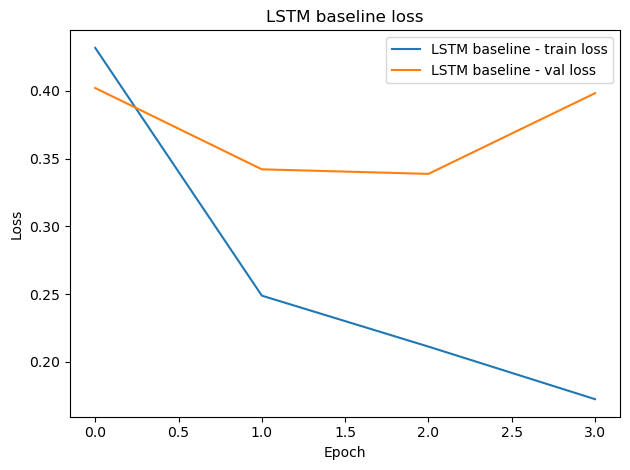

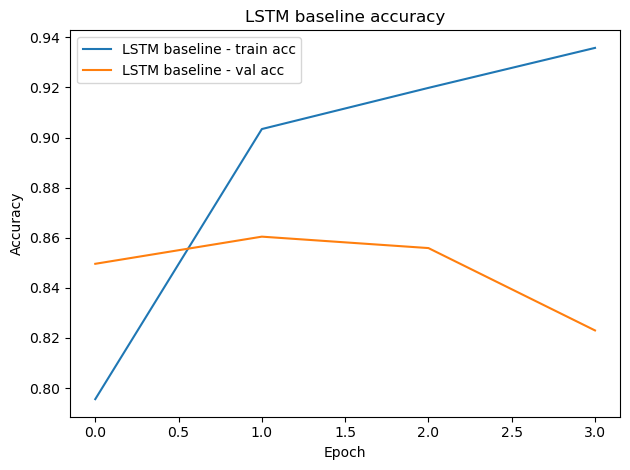

LSTM baseline metrics: {'loss': 0.3388138711452484, 'accuracy': 0.8558800220489502, 'perplexity': 1.4032821296079223}

LSTM Classification Report:
               precision    recall  f1-score   support

           0     0.8835    0.8199    0.8505     12500
           1     0.8320    0.8918    0.8609     12500

    accuracy                         0.8559     25000
   macro avg     0.8577    0.8559    0.8557     25000
weighted avg     0.8577    0.8559    0.8557     25000

LSTM Confusion Matrix:
 [[10249  2251]
 [ 1352 11148]]


In [10]:
plot_history({"LSTM baseline": lstm_hist}, title="LSTM baseline loss", filename="lstm_baseline_loss.png")
plot_accuracy({"LSTM baseline": lstm_hist}, title="LSTM baseline accuracy", filename="lstm_baseline_acc.png")

lstm_base_metrics = evaluate_model(lstm_baseline, X_test, y_test)
print("LSTM baseline metrics:", lstm_base_metrics)

lstm_report, lstm_cm = classification_details(lstm_baseline, X_test, y_test)
print("\nLSTM Classification Report:\n", lstm_report)
print("LSTM Confusion Matrix:\n", lstm_cm)


In [11]:
def run_experiment(model_type, maxlen, batch_size, learning_rate, clipnorm=None, epochs=3):
    # Re-pad sequences for the chosen maxlen
    (X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)
    X_tr = pad_sequences(X_train_raw, maxlen=maxlen)
    X_te = pad_sequences(X_test_raw,  maxlen=maxlen)

    if model_type == "RNN":
        model = build_rnn_model(VOCAB_SIZE, maxlen, learning_rate=learning_rate, clipnorm=clipnorm)
    else:
        model = build_lstm_model(VOCAB_SIZE, maxlen, learning_rate=learning_rate, clipnorm=clipnorm)

    log_file = f"{model_type.lower()}_m{maxlen}_b{batch_size}_lr{learning_rate}_clip{clipnorm}.csv".replace(".", "p")
    hist = train_model(model, X_tr, y_train_raw, X_te, y_test_raw, epochs=epochs, batch_size=batch_size, log_name=log_file)
    metrics = evaluate_model(model, X_te, y_test_raw)

    return metrics, hist

experiments = [
    # baseline-ish
    {"maxlen": 200, "batch_size": 64, "learning_rate": 1e-3},
    # longer sequence
    {"maxlen": 400, "batch_size": 64, "learning_rate": 1e-3},
    # smaller batch
    {"maxlen": 200, "batch_size": 32, "learning_rate": 1e-3},
    # smaller learning rate
    {"maxlen": 200, "batch_size": 64, "learning_rate": 5e-4},
]

results = []
histories_to_plot = {}

for cfg in experiments:
    for model_type in ["RNN", "LSTM"]:
        metrics, hist = run_experiment(
            model_type=model_type,
            maxlen=cfg["maxlen"],
            batch_size=cfg["batch_size"],
            learning_rate=cfg["learning_rate"],
            clipnorm=None,
            epochs=3  # fewer epochs for faster experimentation
        )
        row = {
            "model": model_type,
            "maxlen": cfg["maxlen"],
            "batch_size": cfg["batch_size"],
            "learning_rate": cfg["learning_rate"],
            "clipnorm": None,
            **metrics
        }
        results.append(row)
        histories_to_plot[f"{model_type} m{cfg['maxlen']} b{cfg['batch_size']} lr{cfg['learning_rate']}"] = hist

df_results = pd.DataFrame(results).sort_values(["model", "accuracy"], ascending=[True, False])
df_results


Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.6974 - loss: 0.5511 - val_accuracy: 0.8290 - val_loss: 0.4008
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 33s 83ms/step - accuracy: 0.8287 - loss: 0.3918 - val_accuracy: 0.7942 - val_loss: 0.4539
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 67s 158ms/step - accuracy: 0.7572 - loss: 0.4865 - val_accuracy: 0.8115 - val_loss: 0.4296
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 161ms/step - accuracy: 0.8832 - loss: 0.2903 - val_accuracy: 0.8518 - val_loss: 0.3491
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 58s 149ms/step - accuracy: 0.9217 - loss: 0.2098 - val_accuracy: 0.8545 - val_loss: 0.3462
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 141ms/step - accuracy: 0.6730 - loss: 0.5752 - val_accuracy: 0.8297 - val_loss: 0.3952
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.8432 - loss: 0.3741 - val_accuracy: 0.8200 - val_loss: 0.4174
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 114s 280ms/step - accuracy: 0.7725 - loss: 0.4566 - v

,model,maxlen,batch_size,learning_rate,clipnorm,loss,accuracy,perplexity
7,LSTM,200,64,0.0005,None,0.310635,0.86480,1.364291
3,LSTM,400,64,0.0010,None,0.331329,0.86276,1.392818
5,LSTM,200,32,0.0010,None,0.357105,0.85668,1.429186
1,LSTM,200,64,0.0010,None,0.346175,0.85448,1.413649
6,RNN,200,64,0.0005,None,0.377502,0.83972,1.458637
2,RNN,400,64,0.0010,None,0.395178,0.82972,1.484648
0,RNN,200,64,0.0010,None,0.400773,0.82896,1.492979
4,RNN,200,32,0.0010,None,0.563733,0.70468,1.757219


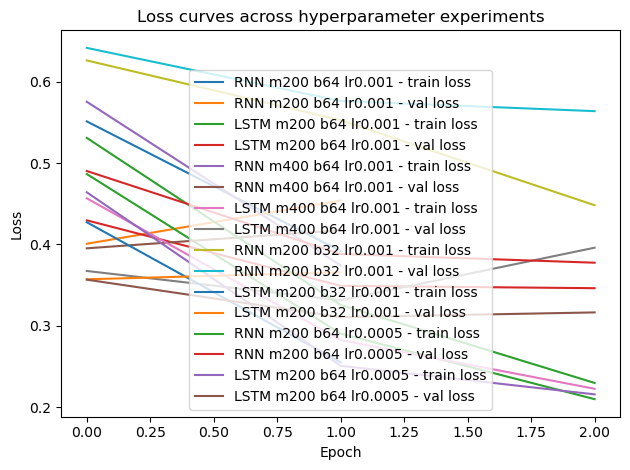

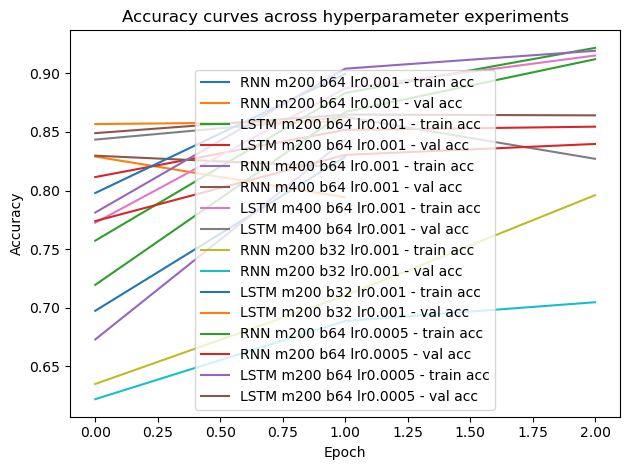

Saved results table to logs/hyperparam_results.csv


In [12]:
plot_history(histories_to_plot, title="Loss curves across hyperparameter experiments", filename="hyperparam_loss_comparison.png")
plot_accuracy(histories_to_plot, title="Accuracy curves across hyperparameter experiments", filename="hyperparam_acc_comparison.png")

df_results.to_csv(os.path.join("logs", "hyperparam_results.csv"), index=False)
print("Saved results table to logs/hyperparam_results.csv")


In [13]:
clipnorm_value = 1.0

# Pick ONE configuration to demonstrate clipping clearly (use your best LSTM config if you want)
cfg = {"maxlen": 200, "batch_size": 64, "learning_rate": 1e-3}

# Re-pad once
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = imdb.load_data(num_words=VOCAB_SIZE)
X_tr = pad_sequences(X_train_raw, maxlen=cfg["maxlen"])
X_te = pad_sequences(X_test_raw,  maxlen=cfg["maxlen"])

# RNN without clipping
rnn_no_clip = build_rnn_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=None)
hist_rnn_no = train_model(rnn_no_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="rnn_no_clip.csv")
m_rnn_no = evaluate_model(rnn_no_clip, X_te, y_test_raw)

# RNN with clipping
rnn_clip = build_rnn_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=clipnorm_value)
hist_rnn_clip = train_model(rnn_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="rnn_clip.csv")
m_rnn_clip = evaluate_model(rnn_clip, X_te, y_test_raw)

# LSTM without clipping
lstm_no_clip = build_lstm_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=None)
hist_lstm_no = train_model(lstm_no_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="lstm_no_clip.csv")
m_lstm_no = evaluate_model(lstm_no_clip, X_te, y_test_raw)

# LSTM with clipping
lstm_clip = build_lstm_model(VOCAB_SIZE, cfg["maxlen"], learning_rate=cfg["learning_rate"], clipnorm=clipnorm_value)
hist_lstm_clip = train_model(lstm_clip, X_tr, y_train_raw, X_te, y_test_raw, epochs=3, batch_size=cfg["batch_size"], log_name="lstm_clip.csv")
m_lstm_clip = evaluate_model(lstm_clip, X_te, y_test_raw)

clip_compare = pd.DataFrame([
    {"model":"RNN", "clipnorm":None, **m_rnn_no},
    {"model":"RNN", "clipnorm":clipnorm_value, **m_rnn_clip},
    {"model":"LSTM", "clipnorm":None, **m_lstm_no},
    {"model":"LSTM", "clipnorm":clipnorm_value, **m_lstm_clip},
])
clip_compare


Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.6788 - loss: 0.5807 - val_accuracy: 0.7182 - val_loss: 0.5445
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8278 - loss: 0.3945 - val_accuracy: 0.7972 - val_loss: 0.4357
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8858 - loss: 0.2803 - val_accuracy: 0.7785 - val_loss: 0.5355
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 55ms/step - accuracy: 0.7008 - loss: 0.5547 - val_accuracy: 0.8326 - val_loss: 0.3942
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.8467 - loss: 0.3660 - val_accuracy: 0.8217 - val_loss: 0.4148
Epoch 1/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 118ms/step - accuracy: 0.8049 - loss: 0.4124 - val_accuracy: 0.8488 - val_loss: 0.3545
Epoch 2/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 84s 123ms/step - accuracy: 0.9024 - loss: 0.2523 - val_accuracy: 0.8542 - val_loss: 0.3437
Epoch 3/3
391/391 ━━━━━━━━━━━━━━━━━━━━ 85s 131ms/step - accuracy: 0.9216 - loss: 0.2046 - val_a

,model,clipnorm,loss,accuracy,perplexity
0,RNN,NaN,0.435717,0.79716,1.546071
1,RNN,1.0,0.394209,0.83260,1.483210
2,LSTM,NaN,0.343705,0.85416,1.410163
3,LSTM,1.0,0.328965,0.86484,1.389530


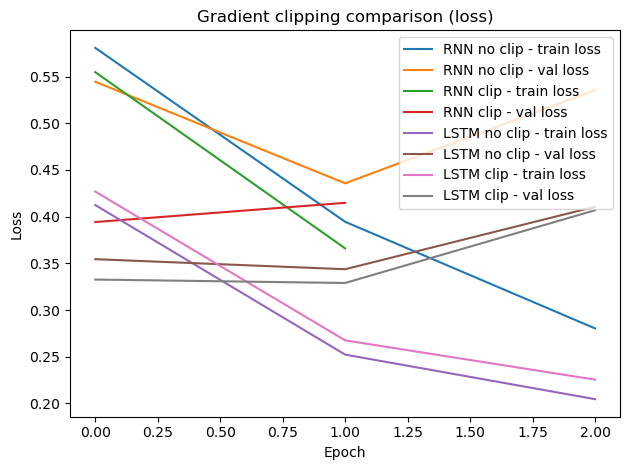

In [14]:
plot_history(
    {
        "RNN no clip": hist_rnn_no,
        "RNN clip": hist_rnn_clip,
        "LSTM no clip": hist_lstm_no,
        "LSTM clip": hist_lstm_clip
    },
    title="Gradient clipping comparison (loss)",
    filename="gradient_clipping_loss.png"
)
